In [2]:
import argparse
import os
import random
from collections import OrderedDict
import imageio

import numba
import numpy as np
import PIL
from gym.spaces import Box, Dict, Discrete

import habitat
from habitat import Config
#from hab_base_utils_common import batch_obs
from habitat_baselines.config.default import get_config
from habitat.utils.visualizations import maps
from habitat.tasks.utils import cartesian_to_polar
from habitat.utils.geometry_utils import quaternion_rotate_vector
#from torchvision import transforms

from env_orb import Env

from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
import glob
import time
from utils import draw_top_down_map, plot_colortable, rand_cmap
import utils_for_vectorenv
import matplotlib.patches as patches
from IPython.display import clear_output
from habitat_sim.utils import viz_utils as vut
from arguments import get_args as get_args_env
import skimage
from utils_f.map_builder_objnav import MapBuilder
import utils_f.pose as pu

ModuleNotFoundError: No module named 'torch'

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [3]:
W = 640
H = 480
config_env = get_config(
    "ddppo_objectnav.yaml", ["BASE_TASK_CONFIG_PATH", 'challenge_objectnav2021.local.rgbd.yaml']).clone()
config_env.defrost()
config_env.TASK_CONFIG.SIMULATOR.AGENT_0.SENSORS.append("SEMANTIC_SENSOR")
config_env.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HEIGHT = H
config_env.TASK_CONFIG.SIMULATOR.RGB_SENSOR.WIDTH = W
config_env.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config_env.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config_env.TASK_CONFIG.SIMULATOR.SEMANTIC_SENSOR.WIDTH = W
config_env.TASK_CONFIG.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = H
config_env.TASK_CONFIG.TASK.POSSIBLE_ACTIONS = ["STOP", "MOVE_FORWARD", "TURN_LEFT", "TURN_RIGHT"]#, "LOOK_UP", "LOOK_DOWN"]

config_env.TASK_CONFIG.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config_env.TASK_CONFIG.TASK.SENSORS.append("HEADING_SENSOR")

"""
config_env.TASK_CONFIG.SIMULATOR.RGB_SENSOR.NOISE_MODEL = 'GaussianNoiseModel'
config_env.TASK_CONFIG.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS = habitat.Config()
config_env.TASK_CONFIG.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.1 #0.02
#config_env.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.NOISE_MODEL = "RedwoodDepthNoiseModel"
#config_env.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.NOISE_MODEL_KWARGS = habitat.Config()
#config_env.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.NOISE_MODEL_KWARGS.noise_multiplier = 2. #2.
config_env.TASK_CONFIG.SIMULATOR.ACTION_SPACE_CONFIG = 'pyrobotnoisy'
config_env.TASK_CONFIG.SIMULATOR.NOISE_MODEL = habitat.Config()
config_env.TASK_CONFIG.SIMULATOR.NOISE_MODEL.ROBOT = "LoCoBot"
config_env.TASK_CONFIG.SIMULATOR.NOISE_MODEL.CONTROLLER = 'Proportional'
config_env.TASK_CONFIG.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.1
"""

config_env.TASK_CONFIG.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = False
config_env.TASK_CONFIG.DATASET.SPLIT = 'train'

config_env.TASK_CONFIG.DATASET.CONTENT_SCENES = ['sT4fr6TAbpF']
config_env.TASK_CONFIG.DATASET.CONTENT_SCENES = ['ZMojNkEp431', 'aayBHfsNo7d', 'cV4RVeZvu5T',
                                                'e9zR4mvMWw7', 'i5noydFURQK', 'jh4fc5c5qoQ',
                                                'mJXqzFtmKg4', 'p5wJjkQkbXX', 'r1Q1Z4BcV1o', 
                                                'rPc6DW4iMge', 'sT4fr6TAbpF']
                                               

config_env.TASK_CONFIG.ENVIRONMENT.MAX_EPISODE_STEPS = 500
config_env.TASK_CONFIG.TASK.TOP_DOWN_MAP.MAX_EPISODE_STEPS = 500
config_env.TASK_CONFIG.DATASET.SCENES_DIR = '/data/scene_datasets/'
config_env.TASK_CONFIG.DATASET.DATA_PATH = '/data/datasets/objectnav/mp3d/v1/{split}/{split}.json.gz'

config_env.freeze()

/habitat-lab/habitat_baselines/config/default.py:246: UserWarning: NUM_PROCESSES is depricated and will be removed in a future version.  Use NUM_ENVIRONMENTS instead.  Overwriting NUM_ENVIRONMENTS with NUM_PROCESSES for backwards compatibility.
  warnings.warn(


In [4]:
%load_ext autoreload
%autoreload 2

# One_env

In [5]:
one_env = Env(config=config_env)

2022-02-19 17:05:57,301 Initializing dataset ObjectNav-v1
2022-02-19 17:06:47,787 initializing sim Sim-v0
2022-02-19 17:06:53,882 Initializing task ObjectNav-v1


[Metadata] AttributesManagerBase.h(360)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default | This file  does not exist.
[Metadata] AssetAttributesManager.cpp(120)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[Metadata] AssetAttributesManager.cpp(120)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[Metadata] AssetAttributesManager.cpp(120)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[Metadata] AssetAttributesManager.cpp(120)::createObject : Asset attributes (coneWireframe:coneWireframe_segments_32_halfLen_1.25) created and registered.
[Metadata] AssetAttributesManager.cpp(1

Number of labels: 42


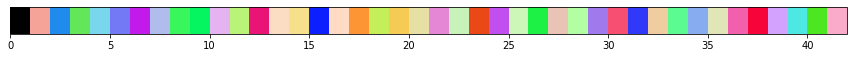

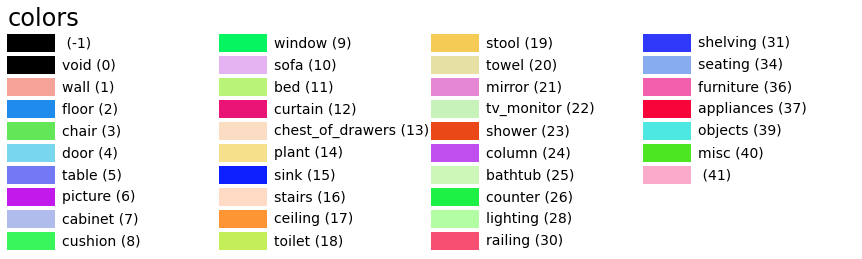

In [7]:
colorss, new_cmap = utils_for_vectorenv.get_colors(one_env)
fig, ax = plot_colortable(colorss, 'colors')
im = utils_for_vectorenv.get_img_from_fig(fig)

Number of labels: 22


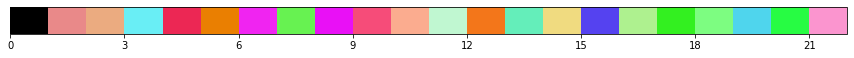

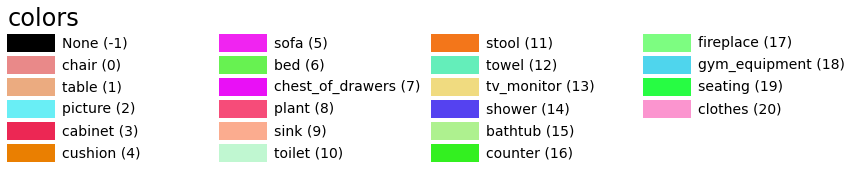

In [8]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

new_colors = list(mcolors.CSS4_COLORS.values())
cmap = LinearSegmentedColormap.from_list('test', new_colors, N=len(new_colors))            
ccmap = matplotlib.cm.get_cmap('jet')   
new_cmap_cat20 = rand_cmap(22, type='bright', first_color_black=True, last_color_black=False, verbose=True)
colorss = {}
elements_in_image = [-1]+list(one_env.objgoal_to_cat.keys())
for i,entry in enumerate(elements_in_image):
    if entry==-1:
        label = 'None (-1)'
        norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=22)
        colorss[label] = new_cmap_cat20(norm(0))
    else:    
        label = one_env.objgoal_to_cat[entry] + ' (' + str(entry)+ ') '
        norm = matplotlib.colors.Normalize(vmin=-1.0, vmax=22)
        colorss[label] = new_cmap_cat20(norm(entry+1))
fig1, ax1 = plot_colortable(colorss, 'colors')
im_cat20 = utils_for_vectorenv.get_img_from_fig(fig1)    

In [9]:
class Mapper:
    def __init__(self):
        arguments = "--split train \
            --auto_gpu_config 0 \
            -n 1 \
            --num_processes_on_first_gpu 5 \
                --num_processes_per_gpu 16 \
            --train_global 0 --train_local 0 --train_slam 0 \
            --slam_memory_size 150000 \
                --exp_name zero-noise \
            --num_mini_batch 9 \
            --total_num_scenes 1 \
            --split train \
            --task_config my_challenge_mp3d_objectnav2020.local.rgbd.yaml \
            --load_global pretrained_models/model_best.global \
            --load_local pretrained_models/model_best.local \
            --load_slam pretrained_models/model_best.slam \
            --max_episode_length 500".split()
        args_env = get_args_env(arguments)
        args_env.hfov = 79
        args_env.env_frame_height = 480
        args_env.env_frame_width = 640
        args_env.env_frame_semantic_height = 480
        args_env.env_frame_semantic_width = 640
        args_env.camera_height = 0.88
        args_env.du_scale = 1
        args_env.map_size_cm = 4800   
        self.args = args_env 

        self.mapper = self.build_mapper()
        full_map_size = args_env.map_size_cm//args_env.map_resolution
        self.mapper.set_class_number(7)
        self.map_size_cm = args_env.map_size_cm
        self.mapper.reset_map(self.map_size_cm)
        
    def reset(self):
        self.mapper.reset_map(self.map_size_cm)
        
        self.collision_map = np.zeros((960,960))
        self.visited = np.zeros((960,960))
        self.curr_loc = [24.,24.]
        self.last_loc = [24.,24.]
        self.curr_loc_map = [24.,24.]
        self.last_loc_map = [24.,24.,0.]
        self.col_width = 1
        self.fat_map = 6
        self.goal_x,self.goal_y = 10,10
        self.poses = [[479,479],[480,480]]
        self.after_reset = 0
        self.last_sim_location = [0.,0.,0.]#self.get_sim_location()
        self.curr_loc_gt = [4800/100.0/2.0,
                         4800/100.0/2.0, 0.]
    
    def step(self,observations):
        
        dx_gt, dy_gt, do_gt = self.get_gt_pose_change(list(observations['gps']*np.array([1,-1]))+list(observations['compass']))
        self.curr_loc_gt = pu.get_new_pose(self.curr_loc_gt,(dx_gt, dy_gt, do_gt))
        self.curr_loc_map = [int((observations['gps'][0]+24) * 100.0/5),
                int((-observations['gps'][1]+24) * 100.0/5)]
        
        sem_hab22 = np.zeros((480,640))
        sem_hab22[one_env.sem_to_model==3] = 1
        sem_hab22[one_env.sem_to_model==10] = 2
        sem_hab22[one_env.sem_to_model==14] = 3
        sem_hab22[one_env.sem_to_model==11] = 4
        sem_hab22[one_env.sem_to_model==18] = 5
        sem_hab22[one_env.sem_to_model==22] = 6
        
        depth = self._preprocess_depth(observations['depth'])
        mapper_gt_pose = (self.curr_loc_gt[0]*100.0,self.curr_loc_gt[1]*100.0,np.deg2rad(self.curr_loc_gt[2]))
        fp_proj, self.map, fp_explored, self.explored_map, fp_semantic, self.semantic_map = \
            self.mapper.update_map(depth, mapper_gt_pose, sem_hab22, 1) #observations['semantic'][:,:,0]

        self.poses.append(self.curr_loc_map)
        
        self.visited[self.curr_loc_map[1]-1:self.curr_loc_map[1], self.curr_loc_map[0] - 0:self.curr_loc_map[0] + 1] = 1
        
        
    def build_mapper(self):
        params = {}
        params['frame_width'] = self.args.env_frame_width
        params['frame_height'] = self.args.env_frame_height
        params['frame_semantic_width'] = self.args.env_frame_semantic_width
        params['frame_semantic_height'] = self.args.env_frame_semantic_height
        params['fov'] =  self.args.hfov
        params['resolution'] = self.args.map_resolution
        params['map_size_cm'] = self.args.map_size_cm
        params['agent_min_z'] = 25
        params['agent_max_z'] = 150
        params['agent_height'] = self.args.camera_height * 100
        params['agent_view_angle'] = 0
        params['du_scale'] = self.args.du_scale
        params['vision_range'] = self.args.vision_range
        params['visualize'] = self.args.visualize
        params['obs_threshold'] = self.args.obs_threshold
        params['classes_number'] = 42

        self.selem = skimage.morphology.disk(self.args.obstacle_boundary /
                                             self.args.map_resolution)
        mapper = MapBuilder(params)
        return mapper 
    
    def get_gt_pose_change(self,loc):
        curr_sim_pose = loc
        dx, dy, do = pu.get_rel_pose_change(curr_sim_pose, self.last_sim_location)
        self.last_sim_location = curr_sim_pose
        return dx, dy, do   
    
    def _preprocess_depth(self,depth):
        depth = depth[:, :, 0]*1
        mask2 = depth > 0.99
        depth[mask2] = 0.

        for i in range(depth.shape[1]):
            depth[:,i][depth[:,i] == 0.] = depth[:,i].max()

        mask1 = depth == 0
        depth[mask1] = np.NaN
        depth = depth*450. + 50.
        return depth 


In [10]:
prev_cat = one_env._episode_iterator.episodes[0].goals[0].object_category
for ii,i in enumerate(one_env.eps):
    nex_cat = one_env._episode_iterator.episodes[i].goals[0].object_category
    if nex_cat!=prev_cat:
        print(ii,'\t',one_env._episode_iterator.episodes[i].scene_id.split('/')[-1],'\t',nex_cat,'\t',np.round(one_env.closest_dist[ii],2))
        prev_cat=nex_cat

0 	 ZMojNkEp431.glb 	 chair 	 7.4
3820 	 ZMojNkEp431.glb 	 tv_monitor 	 3.11
3832 	 aayBHfsNo7d.glb 	 bed 	 6.06
4200 	 aayBHfsNo7d.glb 	 chair 	 11.5
9871 	 aayBHfsNo7d.glb 	 plant 	 3.5
14515 	 aayBHfsNo7d.glb 	 toilet 	 11.48
15285 	 cV4RVeZvu5T.glb 	 plant 	 6.5
18383 	 cV4RVeZvu5T.glb 	 chair 	 4.34
22029 	 e9zR4mvMWw7.glb 	 bed 	 4.41
24656 	 i5noydFURQK.glb 	 chair 	 3.21
44059 	 mJXqzFtmKg4.glb 	 toilet 	 13.1
45458 	 p5wJjkQkbXX.glb 	 chair 	 18.67
56055 	 p5wJjkQkbXX.glb 	 sofa 	 7.29
57247 	 p5wJjkQkbXX.glb 	 toilet 	 8.79
58663 	 p5wJjkQkbXX.glb 	 bed 	 19.21
60056 	 p5wJjkQkbXX.glb 	 plant 	 11.58
60392 	 r1Q1Z4BcV1o.glb 	 chair 	 6.81
66591 	 rPc6DW4iMge.glb 	 sofa 	 6.51
70514 	 rPc6DW4iMge.glb 	 chair 	 8.83
77729 	 rPc6DW4iMge.glb 	 toilet 	 10.46
79798 	 sT4fr6TAbpF.glb 	 chair 	 2.95
91184 	 sT4fr6TAbpF.glb 	 sofa 	 20.89


In [28]:
follower = ShortestPathFollower(one_env.sim, 0.25, False)
ep = 3820
obs = one_env.reset(ep); done = False
obs, reward, done, info = one_env.step(action=2)
obs, reward, done, info = one_env.step(action=3)
top_down_map = draw_top_down_map(one_env.info, obs["heading"][0], obs['rgb'][0].shape[0])
map_sem = Mapper()
map_sem.reset()

[Physics] PhysicsManager.cpp(50)::~PhysicsManager : Deconstructing PhysicsManager
[Scene] SemanticScene.h(43)::~SemanticScene : Deconstructing SemanticScene
[Scene] SceneManager.h(25)::~SceneManager : Deconstructing SceneManager
[Scene] SceneGraph.h(25)::~SceneGraph : Deconstructing SceneGraph
[Sensor] Sensor.cpp(69)::~Sensor : Deconstructing Sensor
[Sensor] Sensor.cpp(69)::~Sensor : Deconstructing Sensor
[Sensor] Sensor.cpp(69)::~Sensor : Deconstructing Sensor
[Scene] SceneGraph.h(25)::~SceneGraph : Deconstructing SceneGraph
[Gfx] Renderer.cpp(72)::~Impl : Deconstructing Renderer
[Gfx] WindowlessContext.h(17)::~WindowlessContext : Deconstructing WindowlessContext
[Metadata] MetadataMediator.cpp(66)::setSimulatorConfiguration : Set new simulator config for scene/stage : /data/scene_datasets/mp3d/ZMojNkEp431/ZMojNkEp431.glb and dataset : default which is currently active dataset.
Renderer: TITAN V JHH Special Edition/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 460.73.01

In [29]:
st_time = time.time()
iii = 0
files = glob.glob('images/*')
for f in files:
    os.remove(f)
start_quat = one_env.sim.get_agent_state().rotation.inverse()
obj_type = 'sofa'    
while not done:
    best_action = follower.get_next_action(one_env.current_episode.goals[0].position)#[-27.55,   0.12, -2.00]
    obs, reward, done, info = one_env.step(action=best_action)
    top_down_map = draw_top_down_map(one_env.info, obs["heading"][0], obs['rgb'][0].shape[0])
    
    map_sem.step(obs)
    
    f = plt.figure(figsize=(20,15))
    ax = f.add_subplot(421)
    ax1 = f.add_subplot(422)
    ax2 = f.add_subplot(434)
    ax3 = f.add_subplot(435)
    ax4 = f.add_subplot(436)

    ax5 = f.add_subplot(4,6,13)
    ax6 = f.add_subplot(4,6,14)
    ax7 = f.add_subplot(4,6,15)
    ax8 = f.add_subplot(4,6,16)
    ax9 = f.add_subplot(4,6,17)
    ax10 = f.add_subplot(4,6,18)

    ax11 = f.add_subplot(4,6,19)
    ax12 = f.add_subplot(4,6,20)
    ax13 = f.add_subplot(4,6,21)
    ax14 = f.add_subplot(4,6,22)
    ax15 = f.add_subplot(4,6,23)
    ax16 = f.add_subplot(4,6,24)

    ax.imshow(obs['rgb'])
    ax.set_title('gps = '+str(np.round(obs['gps'],3)))
    ax1.imshow(obs['depth'][:,:,0],cmap='rainbow')
    ax2.imshow(top_down_map)
    ax3.imshow(map_sem.map+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax3.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
    ax4.imshow(map_sem.explored_map+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax4.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))

    ax5.imshow(np.float32((one_env.sem_to_model)==3)[:,:,np.newaxis])
    ax5.set_title('ObjGoal: '+'3,1')
    ax6.imshow(np.float32((one_env.sem_to_model)==10)[:,:,np.newaxis])
    ax6.set_title('ObjGoal: '+'10,2')
    ax7.imshow(np.float32((one_env.sem_to_model)==14)[:,:,np.newaxis])
    ax7.set_title('ObjGoal: '+'14,3')
    ax8.imshow(np.float32((one_env.sem_to_model)==11)[:,:,np.newaxis])
    ax8.set_title('ObjGoal: '+'11,4')
    ax9.imshow(np.float32((one_env.sem_to_model)==18)[:,:,np.newaxis])
    ax9.set_title('ObjGoal: '+'18,5')
    ax10.imshow(np.float32((one_env.sem_to_model)==22)[:,:,np.newaxis])
    ax10.set_title('ObjGoal: '+'22,6')

    ax11.imshow(map_sem.semantic_map[1]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax11.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
    ax12.imshow(map_sem.semantic_map[2]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax12.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
    ax13.imshow(map_sem.semantic_map[3]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax13.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
    ax14.imshow(map_sem.semantic_map[4]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax14.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
    ax15.imshow(map_sem.semantic_map[5]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax15.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
    ax16.imshow(map_sem.semantic_map[6]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
    ax16.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
    iii+=1
    plt.savefig('images/{}.png'.format(str(iii+10000)[1:]))
    plt.close()
print('FPS: ',(time.time()-st_time))    

[Scene] SceneGraph.h(85)::createDrawableGroup : Created DrawableGroup: 


In [18]:
!ffmpeg -y -framerate 5 -i /root/HABITAT_MAP/images/%04d.png -r 5 -c:v libx264 -pix_fmt yuv420p '../videos/MapRL_'$ep'.mp4';

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

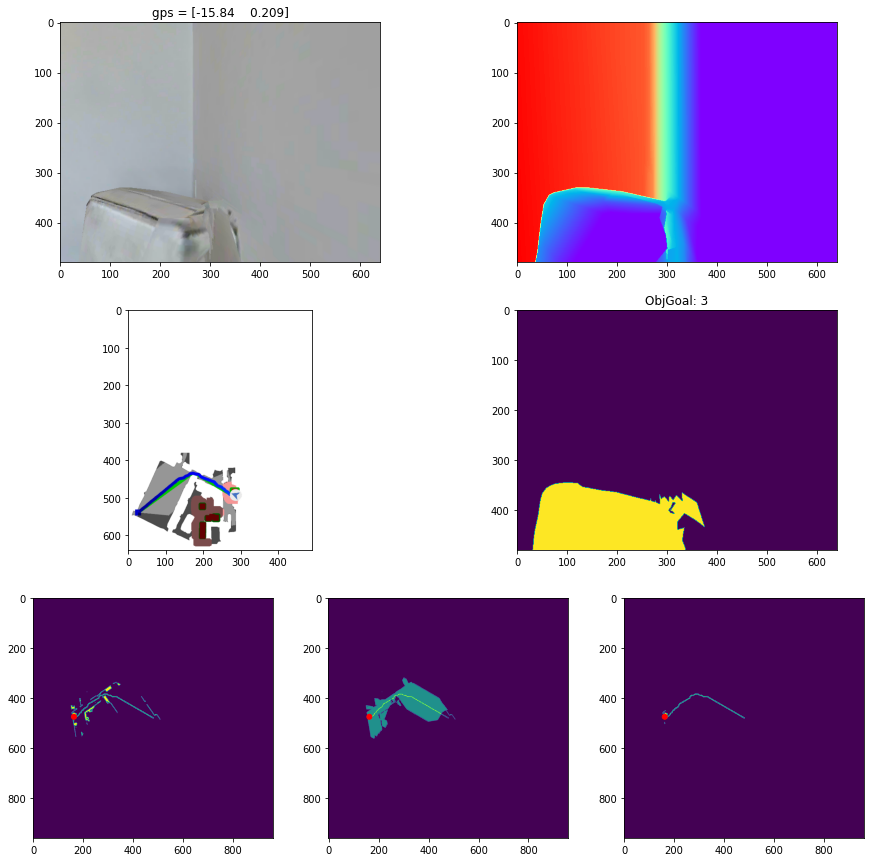

In [26]:
f = plt.figure(figsize=(15,15))
ax = f.add_subplot(321)
ax1 = f.add_subplot(322)
ax2 = f.add_subplot(323)
ax3 = f.add_subplot(324)
ax4 = f.add_subplot(337)
ax5 = f.add_subplot(338)
ax6 = f.add_subplot(339)
ax.imshow(obs['rgb'])
ax.set_title('gps = '+str(np.round(obs['gps'],3)))
ax1.imshow(obs['depth'][:,:,0],cmap='rainbow')
ax2.imshow(top_down_map)
ax3.imshow(np.float32((one_env.sem_to_model)==one_env.objectgoal)[:,:,np.newaxis])
ax3.set_title('ObjGoal: '+str(one_env.objectgoal))
ax4.imshow(map_sem.map+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax4.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax5.imshow(map_sem.explored_map+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax5.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax6.imshow(map_sem.semantic_map[1]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax6.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))

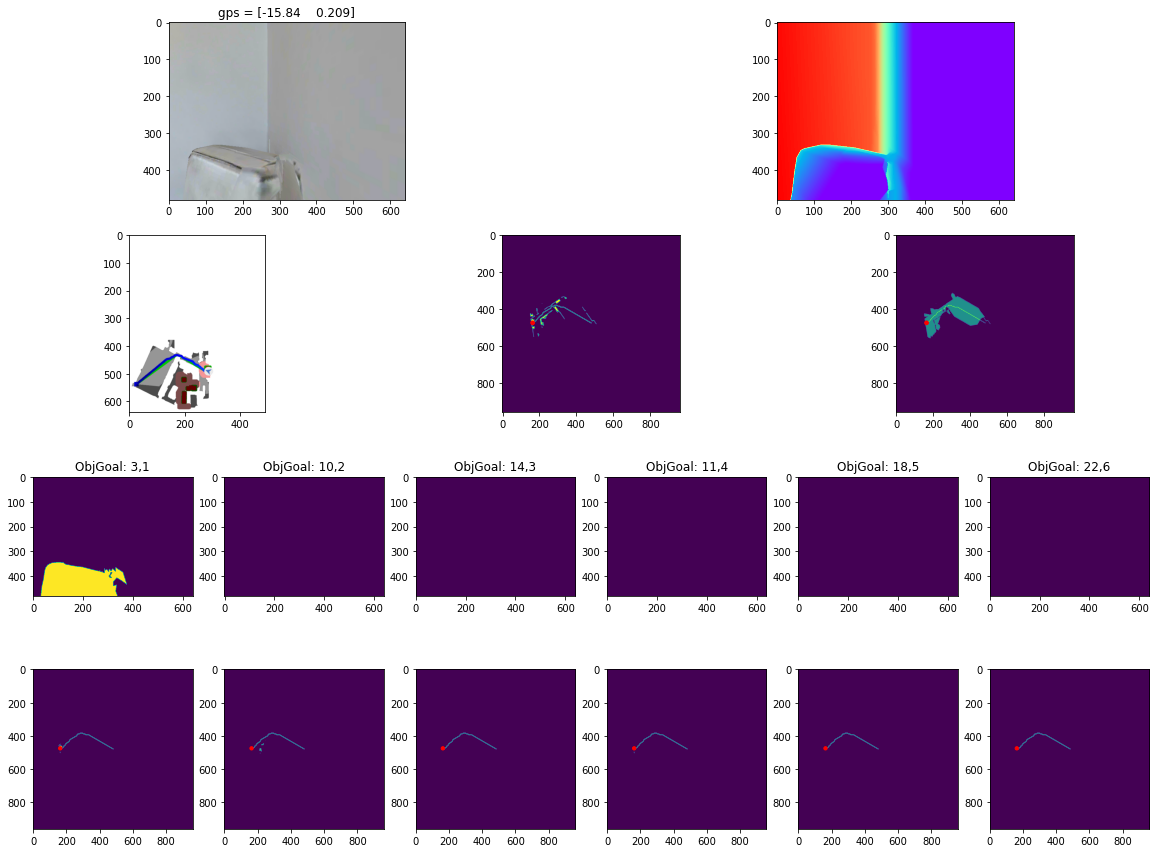

In [27]:
f = plt.figure(figsize=(20,15))
ax = f.add_subplot(421)
ax1 = f.add_subplot(422)
ax2 = f.add_subplot(434)
ax3 = f.add_subplot(435)
ax4 = f.add_subplot(436)

ax5 = f.add_subplot(4,6,13)
ax6 = f.add_subplot(4,6,14)
ax7 = f.add_subplot(4,6,15)
ax8 = f.add_subplot(4,6,16)
ax9 = f.add_subplot(4,6,17)
ax10 = f.add_subplot(4,6,18)

ax11 = f.add_subplot(4,6,19)
ax12 = f.add_subplot(4,6,20)
ax13 = f.add_subplot(4,6,21)
ax14 = f.add_subplot(4,6,22)
ax15 = f.add_subplot(4,6,23)
ax16 = f.add_subplot(4,6,24)

ax.imshow(obs['rgb'])
ax.set_title('gps = '+str(np.round(obs['gps'],3)))
ax1.imshow(obs['depth'][:,:,0],cmap='rainbow')
ax2.imshow(top_down_map)
ax3.imshow(map_sem.map+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax3.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax4.imshow(map_sem.explored_map+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax4.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))

ax5.imshow(np.float32((one_env.sem_to_model)==3)[:,:,np.newaxis])
ax5.set_title('ObjGoal: '+'3,1')
ax6.imshow(np.float32((one_env.sem_to_model)==10)[:,:,np.newaxis])
ax6.set_title('ObjGoal: '+'10,2')
ax7.imshow(np.float32((one_env.sem_to_model)==14)[:,:,np.newaxis])
ax7.set_title('ObjGoal: '+'14,3')
ax8.imshow(np.float32((one_env.sem_to_model)==11)[:,:,np.newaxis])
ax8.set_title('ObjGoal: '+'11,4')
ax9.imshow(np.float32((one_env.sem_to_model)==18)[:,:,np.newaxis])
ax9.set_title('ObjGoal: '+'18,5')
ax10.imshow(np.float32((one_env.sem_to_model)==22)[:,:,np.newaxis])
ax10.set_title('ObjGoal: '+'22,6')

ax11.imshow(map_sem.semantic_map[1]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax11.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax12.imshow(map_sem.semantic_map[2]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax12.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax13.imshow(map_sem.semantic_map[3]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax13.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax14.imshow(map_sem.semantic_map[4]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax14.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax15.imshow(map_sem.semantic_map[5]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax15.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))
ax16.imshow(map_sem.semantic_map[6]+skimage.morphology.binary_dilation(map_sem.visited, selem = skimage.morphology.disk(2)))
ax16.add_patch(Circle(map_sem.curr_loc_map, 10, color='r'))